In [ ]:
# TODO catégories très grandes, histograme de quels mots ont le plus recruté de vidéos

In [123]:
%load_ext autoreload
%autoreload 2
import gc
import pandas as pd 
import numpy as np 
import os 
import os.path as op 
import sys
from tqdm.notebook import tqdm
import re

import matplotlib.pyplot as plt 
import seaborn as sns

sys.path.insert(0, '..') # project folder
from config import * # all paths to files and constants

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [124]:
def clean_non_word(text): #punctuation, underscores seem to evade this regex so add it
        return  re.sub(r'[^\w\s]|_+', ' ', text)

def clean_non_ascii(text): # indian symbols that might still be left
        return  re.sub(r'[^\x00-\x7F]+', ' ', text)

In [125]:
edu = pd.DataFrame()
for i in range(N_BATCHES):
    batch = pd.read_csv(path_edu.format(i), index_col=0).drop(columns = 'description')
    edu = pd.concat([edu, batch])
    del batch
edu = edu.rename(columns={'channel_id': 'channel', 'categories': 'vid_category'})
channels = pd.read_csv(path_channels, compression="infer", sep="\t")
channels = channels[['channel', 'name_cc', 'category_cc']]
edu = edu[['display_id', 'vid_category', 'channel', 'title', 'tags']]
edu = edu.merge(channels, on='channel', how='left')
del channels
edu['text'] = edu['title'].fillna('') + ' ' + edu['tags'].fillna('')
edu = edu.drop(columns=['title', 'tags'])

edu['text'] = edu['text'].apply(clean_non_word).apply(clean_non_ascii)        

In [126]:
category = pd.read_csv(op.join(path_deriv, 'subcategories_1612_16h.csv'))[['display_id', 'category']]
edu = edu.merge(category, on='display_id', how='left')

In [130]:
def select_clean(edu):
    df= edu[(edu.category == '9') |~(edu.category.str.endswith('9') )]
    return df[df.category != 'unclass']

def get_label(numeric_label):
    return content_categories[numeric_label]

def get_numeric_label(label):
    return content_categories.index(label)


def detect_left(keywords, edu, case:bool = False, pre_b = True, post_b = True, search_within = 'unclass'):
    df = edu[edu['category'] == search_within]
    pre = ''; post = ''
    if pre_b:  pre = r'\b'
    if post_b: post = r'\b' 
    keywords = [pre+k+r'\w*'+post for k in keywords]
    keywords = '|'.join(keywords)
    pattern = rf'{keywords}'
    df = df.loc[df.text.str.contains(pattern, case = case, na ='', regex = True)]
    print(f'Length of the dataframe: {len(df)}')
    return df, len(df)

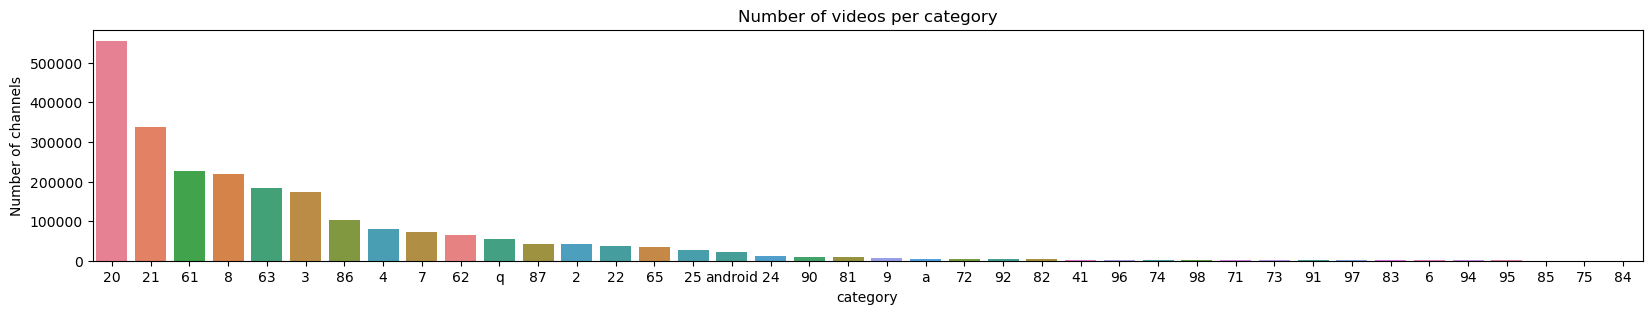

In [131]:
edu = select_clean(edu)
to_plot = edu[edu.category != 'unclass'].copy().drop(columns = ['text'])
fig, ax = plt.subplots(figsize=(20, 3))
sns.countplot(x='category', data=to_plot, order = to_plot.category.value_counts().index, hue = 'category', ax=ax)
#ax.set_yscale('log')
ax.set_title('Number of videos per category')
ax.set_xlabel('category')
ax.set_ylabel('Number of channels')
#ax.legend_.remove()
plt.show()
del to_plot

# Select subcategory to inspect

In [137]:
edu20

,display_id,vid_category,channel,name_cc,category_cc,text,category
0,jCaqrZ8gSkY,Education,UCzWrhkg9eK5I8Bm3HfV-unA,Supertronic,Gaming,Learn Colors and Count to Ten with Colors Disn...,20
1,VZ6_wQxKVSI,Education,UCzWrhkg9eK5I8Bm3HfV-unA,Supertronic,Gaming,Lego city police fireman bank robber boat race...,20
2,0CsvKzQNd7g,Education,UCzWrhkg9eK5I8Bm3HfV-unA,Supertronic,Gaming,Lego Duplo train tracks cartoons railroad chil...,20
21,aqHWsv7PKK4,Education,UCzWn_gTaXyH5Idyo8Raf7_A,Catfish and Carp,Sports,Urban bank fishing for carp Washington DC US...,20
60,f3iJFqXVA_I,Education,UCzWn_gTaXyH5Idyo8Raf7_A,Catfish and Carp,Sports,Surface fishing for carp with popcorn at Smith...,20
...,...,...,...,...,...,...,...
3795447,R_jktAhMvPE,Education,UCrwooWpyfvigpL7kQS_Xc-A,Wellness Digital,Film and Animation,Self Esteem Affirmation Subliminal 3 Raise ...,20
3795456,saYQlmb1y1E,Education,UCrwooWpyfvigpL7kQS_Xc-A,Wellness Digital,Film and Animation,Attract Positive Energy Subliminal Affirmation...,20
3795459,VCoIV9aQ-EA,Education,UCrwooWpyfvigpL7kQS_Xc-A,Wellness Digital,Film and Animation,Affirmations for Self Esteem Self Esteem Aff...,20
3795460,PVhoa-nw-zU,Education,UCrwooWpyfvigpL7kQS_Xc-A,Wellness Digital,Film and Animation,Affirmations for Self Esteem Self Esteem and...,20


In [84]:
# run cell at bottom first
all_keys = kids + tricky + pubg +  ww_i + conspiracy + extra  + general + brands + extra_gaming + case_gaming + games + extra_gaming2 + ml + prog + case_prog + popular_instruments + instruments + composers + classical + styles + festivals + artists_2010s + other_music +   chess + case_chess +  football + american_football + cricket + basketball + baseball + sports + history + extra_history + spirituality + extra_spirit + cooking + diy_and_home_repair_terms + crypto + philosophy_ethics + case_science + science_technology_terms + wildlife_and_animals + case_language+ language_learning + geopolitics 
keys = pd.DataFrame(all_keys, columns = ['keywords'])
keys.keywords  = keys.keywords.apply(lambda x: x.replace('\w*', '').replace('\w+','').replace('.', ' '))

In [135]:
cat = '20'
print(content_categories[cat])
edu20 = edu[edu.category == cat].copy()
del edu

history


['nursery rhyme',
 'sing.along',
 'Twinkle Twinkle',
 'Row Row Row Your Boat',
 'Old MacDonald Had a Farm',
 'Baa Baa Black Sheep',
 'The Wheels on the Bus',
 'If You.re Happy and You Know It',
 'Itsy Bitsy Spider',
 'Five Little Monkey',
 'Baby Shark',
 'Johnny Johnny Yes Papa',
 'London Bridge is Falling Down',
 'Head Shoulders Knees',
 'learn color',
 'learn shapes',
 'learn numbers',
 'alphabet songs',
 'learn ABC',
 'counting songs',
 'preschool learning',
 'early learning',
 'kindergarten',
 'how to count',
 'learning to read',
 'Cocomelon',
 'Peppa Pig',
 'Blippi',
 'Baby Shark',
 'Paw Patrol',
 'Bluey',
 'Dora the Explorer',
 'Thomas and Friend',
 'Masha and the Bear',
 'Barney and Friend',
 'Teletubb',
 'kids storytelling',
 'family-friendly',
 'playtime',
 'DIY for kid',
 'finger painting',
 'pretend play',
 'puppet show',
 'learn animal',
 'learn vehicle',
 'learn the days',
 'learn the months',
 'learn animal',
 'kid\\w* educational song',
 'kid\\w* song',
 'kid\\w* dance',

In [ ]:
# TODO histogram des mots le plus fréquents de chaque categories

In [138]:
edu20

,display_id,vid_category,channel,name_cc,category_cc,text,category
0,jCaqrZ8gSkY,Education,UCzWrhkg9eK5I8Bm3HfV-unA,Supertronic,Gaming,Learn Colors and Count to Ten with Colors Disn...,20
1,VZ6_wQxKVSI,Education,UCzWrhkg9eK5I8Bm3HfV-unA,Supertronic,Gaming,Lego city police fireman bank robber boat race...,20
2,0CsvKzQNd7g,Education,UCzWrhkg9eK5I8Bm3HfV-unA,Supertronic,Gaming,Lego Duplo train tracks cartoons railroad chil...,20
21,aqHWsv7PKK4,Education,UCzWn_gTaXyH5Idyo8Raf7_A,Catfish and Carp,Sports,Urban bank fishing for carp Washington DC US...,20
60,f3iJFqXVA_I,Education,UCzWn_gTaXyH5Idyo8Raf7_A,Catfish and Carp,Sports,Surface fishing for carp with popcorn at Smith...,20
...,...,...,...,...,...,...,...
3795447,R_jktAhMvPE,Education,UCrwooWpyfvigpL7kQS_Xc-A,Wellness Digital,Film and Animation,Self Esteem Affirmation Subliminal 3 Raise ...,20
3795456,saYQlmb1y1E,Education,UCrwooWpyfvigpL7kQS_Xc-A,Wellness Digital,Film and Animation,Attract Positive Energy Subliminal Affirmation...,20
3795459,VCoIV9aQ-EA,Education,UCrwooWpyfvigpL7kQS_Xc-A,Wellness Digital,Film and Animation,Affirmations for Self Esteem Self Esteem Aff...,20
3795460,PVhoa-nw-zU,Education,UCrwooWpyfvigpL7kQS_Xc-A,Wellness Digital,Film and Animation,Affirmations for Self Esteem Self Esteem and...,20


In [ ]:
# TODO 

# inspect keys used

In [86]:
keys['length'] = keys.keywords.apply(len)

In [87]:
# inspect the terms that could make it that videos are wrongly classified as history 

print(keys[keys.length < 4].keywords.values)
# remove most of them except vocab specific

['wwi' 'PvP' 'MMO' 'AMD' 'PHP' 'xml' 'CSS' 'AWS' 'SQL' 'uke' 'R&B' 'rap'
 'Sia' 'U2' 'DJ' 'ELO' 'cr7' 'BMX' 'Ra' 'Set' 'Ur' 'KGB' 'Sin' 'Eid' 'Nun'
 'dua' 'ilm' 'wok' 'pan' 'jam' 'pho' 'diy' 'saw' 'awl' 'MDF' 'OSB' 'DAP'
 'XRP' 'MRI' 'DNA' 'law' 'bee' 'ant' 'cat' 'rat' 'koi' 'pig' 'PKK' 'LRA'
 'YPG']


In [88]:
print(keys[keys.length == 4].keywords.values)
#print(keys[keys.length == 5].keywords.values)

['pubg' 'wwii' 'hoax' 'xbox' 'MOBA' 'DOTA' 'PERL' 'HTML' 'http' 'bass'
 'harp' 'sing' 'bach' 'lied' 'aria' 'jazz' 'rock' 'rave' 'Tyga' 'FIDE'
 'uefa' 'Ajax' 'goal' 'Golf' 'Judo' 'Polo' 'Luge' 'Sumo' 'Gaul' 'Elam'
 'Zeus' 'Hera' 'Ares' 'Isis' 'Odin' 'Loki' 'Chac' 'Inti' 'Troy' 'Susa'
 'tsar' 'emir' 'shah' 'czar' 'Rama' 'Kali' 'Naga' 'Deva' 'Mass' 'Hajj'
 'Puja' 'Arti' 'Holi' 'Lent' 'Monk' 'Imam' 'Yogi' 'Sage' 'Pope' 'psal'
 'mass' 'zion' 'ayah' 'sawm' 'hajj' 'deen' 'iman' 'sabr' 'kufr' 'fiqh'
 'mahr' 'wala' 'cake' 'rice' 'roux' 'sear' 'miso' 'yuzu' 'nori' 'ghee'
 'lard' 'udon' 'naan' 'dosa' 'idli' 'clam' 'mapo' 'tofu' 'duck' 'wine'
 'beer' 'vise' 'weld' 'Aave' 'Kant' 'Hume' 'Mill' 'Zeno' 'NASA' 'CERN'
 'LIGO' 'math' 'gene' 'moth' 'reef' 'frog' 'dove' 'crab' 'duck' 'goat'
 'CEFR' 'DELF' 'DALF' 'JLPT' 'verb' 'ISIS']


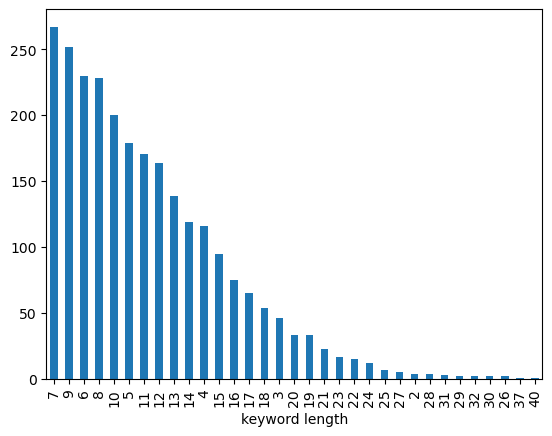

In [89]:
keys.length.value_counts().plot(kind = 'bar', xlabel='keyword length')
plt.show()

In [ ]:
import nltk
from nltk.corpus import brown
nltk.download('brown')

word_freq = nltk.FreqDist(brown.words())
keys['freq'] = keys.keywords.apply(lambda x: word_freq[x.lower()] if x.lower() in word_freq else None) 

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\gbrag\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [116]:
keys.sort_values(by= 'freq',ascending = False).head(30)
# filter these out by hand and put a warning for any above a threshold

,keywords,length,freq
1030,Set,3,408.0
1763,saw,3,350.0
2115,law,3,277.0
1264,history,7,268.0
866,training,8,146.0
1971,moral,5,139.0
1348,Mass,4,89.0
1415,mass,4,89.0
1952,philosophy,10,81.0
360,jazz,4,81.0


In [ ]:
keys[keys.freq < 20].sort_values(by= 'freq',ascending = False).head(30)

In [119]:
from nltk.corpus import webtext
nltk.download('webtext')
webtext_freq = nltk.FreqDist(webtext.words())
keys['freq_W'] = keys.keywords.apply(lambda x: webtext_freq[x.lower()] if x.lower() in webtext_freq else None) 

[nltk_data] Downloading package webtext to
[nltk_data]     C:\Users\gbrag\AppData\Roaming\nltk_data...
[nltk_data]   Package webtext is already up-to-date!


In [122]:
keys[keys.freq_W >6].sort_values(by= 'freq_W',ascending = False).head(30)

,keywords,length,freq,freq_W
489,Train,5,77.0,261.0
1749,wine,4,67.0,249.0
1030,Set,3,408.0,135.0
1264,history,7,268.0,131.0
2354,mouse,5,8.0,116.0
266,http,4,NaN,113.0
258,Javascript,10,NaN,91.0
1327,Phoenix,7,NaN,82.0
1763,saw,3,350.0,72.0
259,HTML,4,NaN,66.0


<Axes: xlabel='freq'>

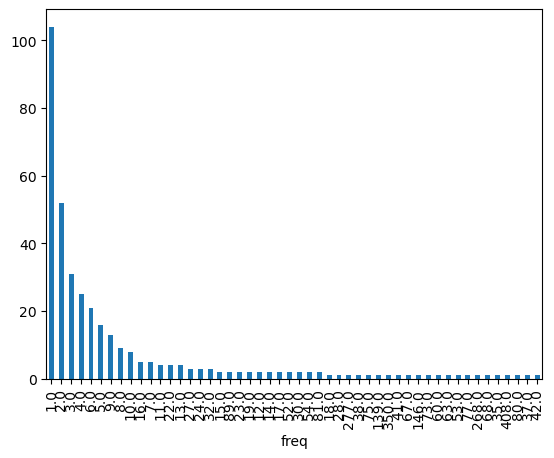

In [ ]:
keys.freq.value_counts().plot(kind = 'bar')

# all lists

In [133]:
#str = """


kids = [r"nursery rhyme",r"sing.along",r"Twinkle Twinkle",r"Row Row Row Your Boat",r"Old MacDonald Had a Farm",r"Baa Baa Black Sheep",r"The Wheels on the Bus",r"If You.re Happy and You Know It",r"Itsy Bitsy Spider",r"Five Little Monkey",r"Baby Shark",r"Johnny Johnny Yes Papa",r"London Bridge is Falling Down",r"Head Shoulders Knees",
    r"learn color",r"learn shapes",r"learn numbers",r"alphabet songs",r"learn ABC",r"counting songs",r"preschool learning",r"early learning",r"kindergarten",r"how to count",r"learning to read",
    r"Cocomelon",r"Peppa Pig",r"Blippi",r"Baby Shark",r"Paw Patrol",r"Bluey",r"Dora the Explorer",r"Thomas and Friend",r"Masha and the Bear",r"Barney and Friend",r"Teletubb",
    r"kids storytelling",r"family-friendly",r"playtime",r"DIY for kid",r"finger painting",r"pretend play",r"puppet show",
    r"learn animal",r"learn vehicle", r"learn the days",r"learn the months", 'learn animal'] + [r"kid\w* educational song",r"kid\w* song", r"kid\w* dance",r"educational video\w* for kid",r"cartoon\w* for kid", r"bedtime stor\w*",r"kid\w* craft",
          r"kid\w* sing.along",r"kid\w* comedy",r"kid\w* yoga",r"kid\w* exercise",r"kid\w* party song",r"animal sound\w* for kid",r"chil\w+ song",r"bab\w+ song",r"lullab\w+"]
pubg = ['pubg'] 
ww_i = ['wwii', 'wwi']
conspiracy = ['conspiracy', 'Qanon', "hoax", "false flag", "deep state", "new world order",     "shadow government", "illuminati",  "psyop", "plandemic",     
              "government mind control","rigged system", "big brother", "surveillance state", "censorship", "black budget", "Area 51",  "crop circles", "ancient aliens",    
              "reptilian", "hollow Earth", "interdimensional beings",  "Bermuda Triangle", "vaccine hoax", "anti-vax", "chemtrails", "fluoride",  "pandemic hoax", "climate hoax", "genetic engineering", "eugenics", "population control", "artificial intelligence takeover", "fake science", 
            "JFK assassination", "9.11 inside job", "moon landing hoax", "flat Earth",'flatist', "holocaust denial", "Freemasons", "Knights Templar", "Zionist conspiracy", "Operation Northwoods",
            "pizzagate", "mass media manipulation", "big tech", "mass surveillance", "AI singularity", "robot uprising", 
            "occult", "satanic ritual", "luciferian", "black magic", "symbolism", "numerology", "astrology conspiracy", "esoteric knowledge", "deep state"
            "occult rituals", "secret worship", "paganism cover-up", "Epstein island","Q drop", "Q clearance", "The Storm", "The Great Awakening","WWG1WGA","elite cabal", "pedo ring", "adrenochrome",  "Great Reset",
    "Hollywood pedophiles","media lie", "sheeple", "Guantanamo Bay", "traitors", "red October"]

extra = ["birds aren.t real", "moon landing hoax", "lizard people", "illuminati confirmed", "reptilian overlords", "bigfoot sightings", "aliens are real", "area 51 raid", "chemtrails" ] 
general = ['gaming', r'esport\w*', 'gameplay', 'playstation']
brands = ['ASUS ROG', 'Razer', 'SteelSeries', 'Corsair', 'HyperX', 'Logitech', 'nvidia','Thrustmaster', 'Blizzard Entertainment', 'xbox', 'Nintendo','Ubisoft']
extra_gaming = ['witcher 2', 'witcher ii', 'BenQ zowie', 'gameboy', 'witcher III', 'witcher 3', 'emulator', 'playstation 4', 'playstation 3','playstation 2', 'playstation 1', 'gta v', 'gta 5', 'gta iv','gta 4', 'gta 3', 'gta iii', 'playstation vita' 'bandicoot', 'assassin.s creed']

case_gaming = ['PvP', 'MMO', 'MOBA','DOTA', 'AMD']
games = ['tetris', 'Grand Theft Auto', 'Epic Games',  'stardew valley' 'Riot Games', 'terraria', 'Elden Ring', 'zelda', 'overwatch', 'Counter.Strike', 'elder scrolls', 'skyrim', 'World of Warcraft', 'apex legends', 'Dead by Daylight', 'EA SPORTS', 'Hearthstone', 'Rainbow Six' ]


extra_gaming = ['witcher 2', 'witcher ii', 'BenQ zowie', 'gameboy', 'witcher III', 'witcher 3', 'emulator', 'playstation 4', 'playstation 3','playstation 2', 'playstation 1', 'gta v', 'gta 5', 'gta iv','gta 4', 'gta 3', 'gta iii', 'playstation vita' 'bandicoot', 'assassin.s creed']
extra_gaming2 = ['command prompt', 'codeblocks', 'program[a-zA-Z]* tutorial', 'mysql', 'unreal engine', 'blender', 'VBscript', 'VB net', 'c sharp', 'for loop', 'if clause',
         r'python program[a-zA-Z]*', r'c program[a-zA-Z]*', r'java program[a-zA-Z]*', r'cnc program[a-zA-Z]*','unity3d', 'unity2d', 'unity c', 'raspberry pi', 'arduino', 'visual studio code', 'geeksforgeeks','PERL', 
         'wordpress','PHP','scala'] + ['xml', 'gamedev', r'vmc program[a-zA-Z]*', 'clever programmer','codecademy', r'R program[a-zA-Z]*', 'install python', 'wxpython', 'javafx', 'cherrypy' ]
ml = [r'neural network', r'Deep Learning', r'Support Vector Machine', r'K.Nearest', r'K.mean', r'Random Forest', r'Markov Chain', r'AdaBoost', r'Hyperparameter', r'Overfitting', r'Gradient Descent', r'Loss Function']
prog = [r'Javascript', r'HTML', r'CSS', r'C\+\+', r'matlab', r'web development', r'software development', r'github', r'http', r'Docker', r'Vscode', r'numpy', r'matplotlib', r'scikit.learn', r'ggplot', r'plotly', r'TensorFlow', r'PyTorch', r'Jupyter']
case_prog = [r'AWS', r'OpenCV', r'SQL']



popular_instruments = ['piano', 'keyboard', 'guitar', 'violin', 'drums', 'ukulele', 'uke']
instruments = ['flute', 'bass','saxophone', 'trumpet', 'clarinet', 'cello', 'trombone' , 'harp', 'sing', 'Accordion', 'bagpipes', 'Mandolin', 'marimba']
composers = ['beethoven', 'mozart', 'haydn', 'bach', 'chopin', 'tchaikovsky', 'handel', 'vivaldi', 'rachmaninoff', 'Mendelssohn', 'debussy', 'stravinsky', 'shostakovich', 'prokofiev', 'sibelius', 'mahler', 'brahms', 'schubert', 'schumann', 'liszt', 'wagner', 'verdi', 'puccini', 'rossini', 'bellini', 'donizetti', 'offenbach', 'meyerbeer', 'gounod', 'massenet', 'saint saens', 'faure', 'debussy', 'poulenc', 'milhaud', 'honneger', 'messiaen', 'dutilleux', 'ravel', 'stravinsky', 'bartok', 'shostakovich', 'prokofiev', 'schnittke', 'ligeti']
classical = ['symphony', 'Sonata', 'cantata', 'Arpeggio', 'perfect pitch', 'syncopation', 'fugue', 'opera', 'operetta',  'cantata', 'lied', 'aria','chorale',  'concerto', 'intermezzo']
styles = ['jazz', 'rock', 'reggae', 'R&B', 'heavy metal', 'hard metal', 'hip.hop', 'rap', 'disco', 'techno', 'dubstep', 'drum and bass', 'rave', 'gregorian chant', 'madrigal', 'rhapsody', 'mazurka', 'polonaise', 'waltz', 'tango', 'rumba', 'samba', 'bossa nova', 'cha cha', 'merengue',  'reggaeton', 'dancehall', 'ragga']
festivals = ['Coachella', 'Glastonbury', 'Tomorrowland', 'Lollapalooza', 'Woodstock', 'Montreux Jazz', 'Rock in Rio', ]
artists_2010s = ['Drake', 'Rihanna', 'Bruno Mars', 'Justin Bieber', 'Nicki Minaj', 'Taylor Swift', 
    'Post Malone', 'Ariana Grande', 'Maroon 5', 'Katy Perry', 'Lady Gaga', 'Lil Wayne', 
    'Ed Sheeran', 'Imagine Dragons', 'Cardi B', 'the Weeknd', 'Pitbull', 'Eminem', 
    'Chris Brown', 'One Direction', 'Selena Gomez', 'Justin Timberlake', 
    'Kesha', 'Kendrick Lamar',  'Lady Antebellum', 'Beyonce', 'Jason Aldean', 
    'Sam Smith', 'Khalid', 'Blake Shelton', 'Travis Scott', 
    'Shawn Mendes', 'Usher', 
    'Mumford...Sons', 'Travi. Scott', 'Jay.Z', 
    'Meghan Trainor', 'Big Sean',  'Coldplay', 
    'Florida Georgia Line',  'DJ Snake', 
    'Flo Rida',  'Michael Buble',  'Zac Brown Band', 'Beyonc.', 
    'Jason Derulo', 'The Chainsmokers', 'Halsey', 
    'Ludacris', 'Kanye West', 'Swae Lee', 'Kenny Chesney', 'Miley Cyrus', 
    'Macklemore', 'Carrie Underwood',  'Wiz Khalifa',  
    'Migos', 'Twenty One Pilots', 'Charlie Puth', 'Fetty Wap', 
    'The Black Eyed Peas', 'XXXTentacion', 'Eric Church', 
    'OneRepublic', 'Juice WRLD', '21 Savage', 'Young Thug', 'Billie Eilish', 
    'Ty Dolla .ign', 'LMFAO', 'Bebe Rexha', 'Britney Spears', 'Chris Stapleton', 
    'Iggy Azalea', 'Calvin Harris', '2 Chainz', 'Britney Spears',  
     'Sia', 'Ne.Yo', 'Pentatonix', 'Christina Aguilera', 'Kidz Bop Kidz', 'Juicy J', 
    'David Guetta', 'Quavo', 'U2', 'Lil Nas X', 'Ellie Goulding', 'Bastille', 'The Lumineers', 
    'Daft Punk', 'Pharrell Williams', 'The Rolling Stones', 'Marshmello', 'Train', 
    'Luke Bryan', 'Trey Songz', 'Snoop Dogg', 'Demi Lovato',  'Sam Hunt', 
    'Enrique Iglesias',  'Taio Cruz', 'Camila Cabello', 'Tyga', 'Lil Uzi Vert', 
    'Alessia Cara', 'Panic. at the Disco', 'will.i.am', 'Miranda Lambert', 
    'Bruce Springsteen', 'Kelly Clarkson', 'Jeremih',  'Charli XCX', 
    'Lil Baby', 'Thomas Rhett', 'John Legend', 'Meek Mill',  'Keith Urban', 
    'Lorde', 'Bon Jovi', 'Carly Rae Jepsen', '5 Seconds of Summer', 'Paul McCartney', 'G.Eazy']

other_music = ['concert', 'karaoke', 'musical', 'garage band', 'sheet music', 'Soundtrack','songwriter', 'DJ']  
chess = ['chess opening', 'chess board', 'chess engine','chess olympiad','world chess', 'chess move','chess tournament', 'pawn promotion', 'chess composition', 'chess theory','Stalemate', 'Zugzwang', 
         'En passant', 'Castling', 'Gambit', 'Pawn structure', 'Sicilian Defense', 'Caro-Kann', 'King\S* Indian Defense', 'Queen\S* Gambit', 'queen sacrifice', 'rook sacrifice', 'bishop sacrifice',
         'deep blue','Ruy Lopez', 'Scandinavian Defense','Gukesh Dommaraju', 'World Chess Championship','chaturanga', 'Magnus Carlsen','José Capablanca','Vasily Smyslov','Viktor Korchnoi','Alexander Alekhine', 
         'Magnus Carlsen', 'Hikaru', 'Hikaru Nakamura', 'Mikhail Botvinnik', 'Emanuel Lasker', 'Garry Kasparov', 'Maxime Vachier-Lagrave','Kasparov', 'Anatoly Karpov','Bobby Fischer', 'Shakhriyar Mamedyarov',
         'Judit Polgar','Fabiano Caruana', 'Wesley So', 'Vishy Anand', 'Levon Aronian','International Chess Federation', 'perpetual check', 'pawnless', 'Grandmaster','International Master', 'International Grandmaster',
         'H.J.R. Murray', 'pawn structure','Lichess', 'Chess.com','Tata Steel Chess','Sinquefield Cup',
         'FIDE World', 'Bullet chess', 'blitz chess', 'rapid chess', 'fischer random', 'Stockfish', 'AlphaZero', 'Leela Chess Zero', 'Komodo','Chess puzzle']
case_chess = ['FIDE', 'ELO'] 


football = ["goalkeeper",'uefa','cross bar challenge', "corner kick","free kick","penalty shootout","offside","video assistant referee","hat-trick","Champions League","FIFA World Cup","La Liga","Premier League","Serie A", 'Serie B'"Bundesliga","goal line technology",'cr7', 
"Lionel Messi", "Cristiano Ronaldo", "Neymar", "Kylian Mbapp.", 'Mbappe', 'Mbappé', "Zlatan","Ibrahimovic", "Luka Modric", "Karim Benzema", 'benzema', "Mohamed Salah", 
    "van Dijk", "Lewandowski", "Haaland", "Kevin De Bruyne", "Marta Vieira da Silva", "Megan Rapinoe", "Alex Morgan", "Sam Kerr", "Vivianne Miedema", "Lucy Bronze", "Ada Hegerberg", "Amandine Henry",
    "Manchester United", "Manchester City", "Arsenal", "Tottenham Hotspur", "Newcastle United", "Leeds United", "Aston Villa", "West Ham United", "Brighton & Hove Albion","Wolverhampton Wanderers", "Leicester City",  "Crystal Palace", "Brentford", "Sheffield United"
    "Real Madrid", "Barca", "Atletico Madrid", "Real Betis", "Villarreal", "Real Sociedad",  "Athletic Bilbao", "Celta Vigo", "Rayo Vallecano", "Espanyol", 
    'calcio', "AC Milan", "Inter Milan", "Juventus", "ssc Napoli", "As Roma", "ss Lazio", "Atalanta bc", "acf Fiorentina", "Torino fc", "ac Monza"
    "Bayern Munich", "Borussia Dortmund", "RB Leipzig", "Bayer Leverkusen", "Eintracht", "Borussia M.nchengladbach", "Schalke 04", "Union Berlin", "Hertha Berlin","Augsburg", "Werder Bremen", "Hamburger SV"
    "Paris Saint.Germain", "Olympique Marseille", "Olympique Lyon", "as Monaco", 
    'benfica', 'futebol clube porto',"Sporting CP", "Ajax", "PSV Eindhoven","Galatasaray", "Fenerbah.e", "Be.ikta.",
    "LA Galaxy", "Los Angeles FC", "New York City FC", "Seattle Sounders", "Atlanta United", "Inter Miami", "Orlando City SC",
]

american_football = ["quarterback","linebacker","wide receiver","running back","field goal","Super Bowl","college football","two-point conversion","yard line", "Tom Brady", "Patrick Mahomes", "Aaron Rodgers", "Peyton Manning", 
            "Joe Montana", "Drew Brees", "Russell Wilson", "Odell Beckham Jr",
            "Ezekiel Elliott", "J.J. Watt", "Travis Kelce", "Saquon Barkley",
            "Lamar Jackson", "DeAndre Hopkins", "Tyreek Hill", "Von Miller",
             "Rob Gronkowski", "Walter Payton", "Jerry Rice", "Jim Brown", "Dallas Cowboys", "New England Patriots", "Green Bay Packers", 
            "Kansas City Chiefs", "Pittsburgh Steelers", "San Francisco 49ers", 
            "Chicago Bears", "Seattle Seahawks", "New York Giants", "Buffalo Bills",
         "Los Angeles Rams", "Philadelphia Eagles", "Denver Broncos", 
          "Baltimore Ravens", "Indianapolis Colts", "Tampa Bay Buccaneers"]


cricket = ['cricket',"Indian Premier League","The Ashes", "Virat Kohli", "Sachin Tendulkar", "MS Dhoni", "Steve Smith",
            "Kane Williamson", "Joe Root", "Ben Stokes", "AB de Villiers","Jacques Kalli", "Ricky Ponting", "Muttiah Muralitharan", "Shane Warne",
            "Lasith Malinga", "Brett Lee", "Ellyse Perry", "Mithali Raj","Harmanpreet Kaur", "Jhulan Goswami", "Meg Lanning", "Heather Knight",
            "Mumbai Indian", "Chennai Super King", "Kolkata Knight Rider","Sydney Sixer", "Perth Scorcher", "Surrey County Cricket", 
            "Mumbai Cricket", "Guyana Amazon Warrior", "Barbados Royal", "Karachi King", "Islamabad United", 
            "Melbourne Star", "Hampshire County Cricket", "Central Stag", "Delhi Capital"
]

basketball = ['basketball', "March Madness",
                "Los Angeles Lakers", "Boston Celtics", "Golden State Warriors","Chicago Bulls", "Miami Heat", "San Antonio Spurs", "Brooklyn Nets", "Phoenix Suns", "Dallas Mavericks", "Philadelphia 76ers", "Milwaukee Bucks", "New York Knicks", "Utah Jazz", "Denver Nuggets", 
                "Toronto Raptors", "Houston Rockets","Michael Jordan", "LeBron James",'lebron', "Kobe Bryant", "Shaquille O'Neal", "Steph Curry", "Kevin Durant", "Tim Duncan", "Magic Johnson", "Larry Bird", "Wilt Chamberlain", "Kareem Abdul-Jabbar", "Giannis Antetokounmpo","Dirk Nowitzki", "Scottie Pippen", "Sue Bird", "Diana Taurasi", "Maya Moore", "Breanna Stewart", "Candace Parker", "Lisa Leslie"
            ]

baseball = ['baseball', "Babe Ruth", "Jackie Robinson", "Hank Aaron", "Willie Mays",  "Derek Jeter", "Albert Pujols", "Barry Bonds", "Clayton Kershaw",
    "Mike Trout", "Nolan Ryan", "Ted Williams", "Ken Griffey Jr.",  "Alex Rodriguez", "Joe DiMaggio", "Sandy Koufax", "Mariano Rivera", "Mookie Betts", "Shohei Ohtani", "Ichiro Suzuki", "Cy Young",
    "New York Yankees", "Los Angeles Dodgers", "Boston Red Sox", "Chicago Cubs", "San Francisco Giants", "Houston Astros", "Atlanta Braves", "St. Louis Cardinals", "Oakland Athletics", 
    "Philadelphia Phillies", "Detroit Tigers", "Cleveland Guardians", "San Diego Padres", "Minnesota Twins", "Toronto Blue Jays", 
    "Seattle Mariners", 
]

sports =["athletics","goal","training","halftime","sportsmanship","medal", 'olympic', 'Jeux olympiques', "Archery", "Athletics", "Badminton", "Baseball", 'Slalom',"Boxing", r"Canoe\w*",'BMX', 'bicycle',"Cycling", "Mountain Bike", "Road Cycling", 
    "Diving", "Golf", "Gymnastics", "Trampoline", "Handball", "Hockey", "Judo", "Karate", "Pentathlon", "Rowing", "Rugby", "Skateboard", "Sport Climbing", "Surfing", "Swimming", "Table Tennis", 'ping.pong', "Taekwondo", "Tennis", "Triathlon", "Volleyball", 
    "Polo", "Weightlift", "Wrestling", "Biathlon", "Bobsleigh", "Cross-Country Skiing", "Curling", "Skating", "Freestyle Skiing", "Luge", "Ski Jump", "Snowboard",
    "Kabaddi", "Floorball", "Lacrosse", "Futsal","Kickboxing", "Muay Thai", "Jiu-Jitsu", "Kung Fu",  "Aikido", "Jeet Kune Do", "Capoeira", "Savate",  "Krav Maga", "Wushu", "Wakeboard"
    "jetski", r"Freediv\w+", r"Spearfish\w*","Squash", "Padel", "Pickleball", "Racquetball"
    "Parkour", "Bouldering", "Wingsuit", "Bungee Jumping", "Motocross", "Skating", "Bowling", "Darts",  "Sepak Takraw", "Teqball", "Petanque",  "Cheerleading",  "Boccia", "Goalball", "Archery", "Athletics", 
    "Powerlifting","Fencing","Sumo", "Kabaddi", "Pencak Silat", "Sepak Takraw", "Dragon Boat Racing", "Buzkashi", "Kitesurf",'Bodyboard', 'windsurf',"Shinty", "Basque Pelota",'Jet.Ski', 'Kayak', 'sailing' , 'Stand.Up Paddle'
]

history = [
    "Babylon", "Sumer", "Carthage", "Assyria", "Phoenicia", "Byzantium", "Hittite", "Persian", "Mesopotamia", "Gaul", "Akkadia",  "Etruria", "Elam", "Lydia", "Urartu", "Minoa","Hammurabi", "Nebuchadnezzar", "Gilgamesh", "Ashoka", "Cleopatra",  "Ramses", "Hatshepsut", "Akhenaten", "Tutankhamun", "Charlemagne", 
    "Attila", "Genghis Khan", "Kublai Khan", "Alexander the Great", "Julius Caesar", "Marcus Aurelius", "Constantine", "Harun al-Rashid", "Alaric", "Boudica", "Joan of Arc", "Leonidas", "Pericles", "Theodora", "Hypatia", "Suleiman the Magnificent", "Tamerlane",
    'olympus', 'cyclops', "Zeus", "Poseidon", "Hades", "Apollo", "Athena", "Hera", "Ares", "Hermes", "Artemis", "Dionysus", "Persephone", "Ra", "Isis", 
    "Osiris", "Horus", "Set", "Anubis", "Bastet", "Amaterasu", "Susanoo", "Tsukuyomi", "Odin", "Loki", "Freya",  "Heimdall", "Baldur", "Huitzilopochtli", "Quetzalcoatl", "Tezcatlipoca", 
    "Ixchel", "Chac", "Inti", "Viracocha", "Pachamama", "Tlaloc",    "Troy", "Atlantis", "Nineveh", "Pompeii", "Ecbatana", "Tenochtitlan",     "Machu Picchu", "Palmyra", "Hattusa", "Knossos", "Teotihuacan",    "Angkor", "Petra", "Persepolis", "Mohenjo-Daro",   "Harappa", "Ur", "Susa", "Meroë",
    "Dead Sea Scrolls", "Shroud of Turin", "Terracotta Army", "Golden Fleece", "Ark of the Covenant", "Excalibur", "Holy Grail", 
    "Stonehenge", "Hanging Gardens", "Colossus of Rhodes",  "Library of Alexandria", "Antikythera Mechanism", "Sphinx", "Ziggurat",  "Pantheon", "Acropolis",
    "Paleolithic", "Neolithic", "Bronze Age", "Iron Age", "Antiquity", "Middle Ages", "Renaissance", "Reformation", "Enlightenment", "Industrial Revolution",
    "centurion", "samurai", "shogun",   "vizier", "janissary", "mamluk", "satrap", "praetorian guard", "knight-errant", "caliphate", "crusade",   "reich", "dynasty", "empire",
    "Gilgamesh", "Iliad", "Odyssey", "Aeneid", "Bhagavad Gita",     "Mahabharata", "Ramayana", "Book of the Dead", "Analects",     "Tao Te Ching",  "Summa Theologica",   "Peloponnesian War", 
    "pharaoh", "consul", "tsar", "kaiser", "emir", "viceroy", "archduke",  "shah", "imperator", "thane", " caliph", "czar",
    "Crusade", "Hundred Years. War", "War of the Roses", "Peloponnesian War",    "Pax Romana", "Constantinople", "Great Schism", "Renaissance", "Age of Exploration", "Westphalia", 
    "Meiji Restoration", "Partition of India", "American Revolution",     "French Revolution", "Battle of Hastings", "Black Death","mummy", "feudalism",  "oracle", 
    "Cold War", "Space Race", "Iron Curtain",  "Vietnam War",  "Decolonization",   "Great Depression", "New Deal",  "Roaring Twenties", "World War I", "World War II",  "Post-War Reconstruction", "Marshall Plan", 
    "Warsaw Pact", "Cultural Revolution", "Domino Theory",  "Red Scare", "Nuremberg Trials", "Partition of Palestine", 'holocaust',  "Partition of India", "Nehruvian Era",
    "fascism", "nazism", "apartheid",  "imperialism", "anti-colonialism", 
    "Roosevelt", "Winston Churchill", 'churchill', "Joseph Stalin",'stalin','ussr' "Adolf Hitler", 'hitler', "Mahatma Gandhi",   "Jawaharlal Nehru", "John F. Kennedy",  "Martin Luther King",
    "Che Guevara", "Fidel Castro", "Ho Chi Minh",   "Charles de Gaulle", "Mao Zedong",   "Chiang Kai.shek", "Hirohito", "George Patton",   "Dwight D. Eisenhower", "Nikita Khrushchev", 
    "Leonid Brezhnev", "Harry S. Truman", "Lyndon B. Johnson",  "Richard Nixon", "Golda Meir",
    "Battle of Midway", "Stalingrad","Blitzkrieg", "Operation Overlord", "Pearl Harbor",  "Manhattan Project", "Hiroshima", "Nagasaki",  "Korean War", "Gulf of Tonkin", "Tet Offensive",  "Treaty of Versailles", "Potsdam Conference", 
    "Yalta Conference", "Cuban Missile Crisis",   "Montgomery Bus Boycott",  "Black Panthers", "March on Washington",  "Satyagraha", "Salt March", "Kwame Nkrumah",   "Julius Nyerere", "Patrice Lumumba", "Nelson Mandela",
    "Apollo 11", "Sputnik", "Lunar Module",  "Neil Armstrong", "Buzz Aldrin", "Yuri Gagarin", "Vostok", "Gemini",   "Mercury Program", "Jodrell Bank",     "Berlin Wall", "Checkpoint Charlie", "Hiroshima Peace Memorial",  "Independence Hall", "Selma Bridge",  "Iwo Jima Memorial",
    "KGB", "Third Reich",  "Axis Powers", "Allied Powers",  "Vietnamese National Front",  "Watergate", "Bay of Pigs", "Rosenberg Trials",   "Hollywood Ten", "Munich Massacre", "My Lai Massacre",     "Chernobyl", "Cuban Revolution",
    "Iron Curtain", "Berlin Airlift", "Moon Landing"]
extra_history = ['paleontology', 'archaeology', 'historical', 'medieval'] + ['history']

spirituality = ['spirituality', "Bible", "Quran", "Torah", "Tanakh", "Vedas", "Upanishads", "Bhagavad Gita", "Talmud", "Hadith", "Tripitaka", "Dhammapada", "Guru Granth Sahib", "Avesta", "Zend-Avesta", "Mormon",
    "Yahweh", "Allah", "Jesus", "Christ", "Buddha", "Krishna", "Shiva", "Vishnu", "Ganesha", "Lakshmi", "Hanuman", "Holy Spirit", "Jehovah", "Adonai", "Elohim", "Rama", "Parvati", "Durga", "Kali", "Ahura Mazda", 
    "Moses", "Muhammad","John the Baptist", "Saint Peter", "Saint Paul", "Saint Augustine", "Saint Francis", "Saint Teresa", "Joan of Arc", "Martin Luther", "Calvin", "Guru Nanak", "Mahavira", "Zoroaster", 
    "Archangels", "Djinn", "Asura", "Yaksha", "Naga", "Rakshasa", "Gandharva", "Deva", "Valkyrie", "Fairy", "Satyr", "Centaur", "Phoenix", 
    "Mecca", "Nazareth", "Mount Sinai", "Mount Zion", "Kailash", "Varanasi", "Lumbini", "Bodh Gaya",  "Amritsar", "Monastery", "Abbey", "Chapel", "Synagogue", "Pagoda", "Stupa", "Cathedral", "Temple", 'shrine'
    "Baptism", "Eucharist", "Confession", "Mass", "Hajj", "Salah", "Fasting", "Meditation", "Puja", "Arti", "Yagna", "Namaz", "Mantra",  "Prayer", "Rosary", "Ordination", "Sacrament",
    "Sin", "Karma", "Dharma", "Nirvana", "Samsara", "Moksha", "Resurrection", "Reincarnation", "Purgatory", "Afterlife", 'meditation', 
    "Crucifix", "Chalice", "Ciborium", "Menorah", "Altar", "Tabernacle", "Tefillin", "Rosary", "Reliquary", "Ramadan", "Eid", "Yom Kippur", "Hanukkah", "Holi", "Vesak", "Lent", "Ash Wednesday", "Good Friday", "Rosh Hashanah", "Navaratri", "Durga Puja", "Thaipusam",
    "Monk", "Nun", "Priest", "Imam", "Rabbi", "Swami", "Yogi", "Shaman", "Mystic", "Hermit", "Sage", "Oracle", "Prophetess", "Pope", "Cardinal", "Bishop", "Caliph", "Mysticism", "Asceticism"
]
extra_spirit = [r'psal\w+', 'mass', 'requiem', 'mohammed', 'prophet', r'exorcis\w+',
    "prophecy","parable", "scripture", "expiation", "idolatry", "monotheism", "polytheism",  "piety", "fasting", "pilgrimage","apostasy", "sanctification","blasphemy",  "sanctity", "afterlife", "hellfire",  "sabbath",
    "beatitude", "sermon", "epistle", "testament","decalogue", "sabbath", r"anoint\w*",  "exodus", "manna", "pharisee", "sadducee", "gospel", r"eucharist\w*", "baptism", "trinity", 
    r"beatif\w+", "sacrament", "crucifixion", "zion", r"messiah\w*",r"prophet\w*", "psalter","surah", "ayah", "tajweed", "sharia","hadith", "sunnah", "qibla", "adhan", "zakat", "sawm", "hajj", "umrah", 
    "fitrah", "dhikr", "dua", "jannah", "jahannam", "tawheed", "deen", "akhirah", "shirk", "halal",  "iman", "taqwa", "sabr", "shukr", "kufr", "munafiq", "jihad", "fiqh", "fatwa", "ijtihad", "qiyas", "hadith qudsi", 
    "shura", "hikmah", "ilm", "ikhwan", "risalah", "aqeedah", "mahr", "wala","zalim", "shaheed", "ummah", "muhajir", "ansar", "tafsir", "nasikh", "mansukh","mala'ika", "ruhul qudus", "nifaq","eternal life","divine", 
    "eternal damnation", "heavenly light", "sacred trust", "spiritual guidance", "mystic knowledge", "spiritual", 'adam and eve'
]

cooking = ['cooking',"mandoline", "microplane", "spatula", "skillet", "wok", "tagine","tandoor",'tandoori', "colander", "zester", "rolling pin", "pastry", "mezzaluna", "pepper mill", "spoon",
    "ladle", "bench scraper", "peeler", "grater","knife", "cleaver", "butcher block", "blender", "pestle",'mortar', "bain.marie", "Dutch oven","ramekin", "cookie", "cake", "pan",
    "ice cream","sous vide", "food processor","pressure cooker", "rice", "stockpot", "griddle", "piping bag", "salad", "citrus", "melon","pasta", "tamis", "potato", "spice",
    "braising", r"saut.ing", "julienne", "maceration", "tempering", "roux", "beurre", r"blanch\w+", r"deglaz\w+", r"emulsif\w+", "proofing", r"carameliz\w+", 
    r"ferment\w*", r"poach\w*", r"sear\w*", r"marinat\w+", "confit", "curdling", 'jam', r"roast\w*",
    "saffron", "truffle", "sumac", "tamarind", "miso", "kombu", "yuzu", "ponzu", "amaranth", "quinoa", "farro", "freekeh","barberries", "vermouth", "creme fraiche", "mascarpone", "fontina", "pecorino", "burrata", "paneer", "gorgonzola",
    "anchovy", "capers", "kimchi", "gochujang", "furikake", 'parmesan', 'parmiggiano',"nori", "wasabi", "adzuki", "tamari", "mirin","guanciale", "prosciutto", "pancetta", "kefir", "labneh",
    "ghee", "lard", "tallow", "duck fat","ratatouille", "bouillabaisse", "cassoulet", "coq au vin","chateaubriand", "paella", "tapas", "gazpacho", "tortilla",
    "gnocchi", "risotto", "carbonara", "osso buco", "tiramisu","strudel", "goulash", "pierogi", "borscht", "pelmeni", "blini", "baklava", "dolma", "shawarma","tabbouleh", "hummus", "shakshuka", "falafel",
    "kimchi", "bibimbap", "bulgogi", "ramen", "sushi", "sashimi", "tempura", "teriyaki", "udon", "katsu", "pho", "banh mi","som tam", "pad thai", "laksa", "rendang", "naan", "rogan josh", "vindaloo", "dosa", "idli", "sambar", "khichdi", "gulab jamun",
    "pavlova", "lamington", "churros", "arepas","empanadas", "tamales", "ceviche", "asado", "clam", "jambalaya", "gumbo","chow mein", "mapo","tofu", "duck",
    "Gordon Ramsay",'Ramsay', "Julia Child", "Anthony Bourdain", "Ina Garten", "Thomas Keller", "Alice Waters","Ferran Adrià", "Massimo Bottura", "Heston Blumenthal","Wolfgang Puck", "Marco Pierre White", "Alain Ducasse","Joël Robuchon", "Jamie Oliver", "Nigella Lawson",
    "Emeril Lagasse", "Rick Bayless", "David Chang","Ottolenghi", "José Andrés", "Rachel Ray","Paul Bocuse", "Rene Redzepi", "Grant Achatz","Pierre Hermé", "Dominique Ansel",
    "umami", "mise en place", "terroir", "degustation", "artisanal", "locavore", "farm.to.table", "gastronomy", "cuisine", "a la carte", "charcuterie", "patisserie", "fromagerie",
    "boucherie", "rôtisserie", "brasserie", "bistro", 'foodporn',  "stir-fry", "barbecue", r"grill\w*", "broiling",  r"pickl\w+",
    "sommelier", "mixology", "crockpot", 'wine', 'beer', "reduction", "garnish", "quenelle","souffle", "meringue", "ganache", "fondant", "praline"
]

diy_and_home_repair_terms = ['renovation', 'diy', "jigsaw", "bandsaw", "saw","impact driver", "drill",
    "rotary tool", "multitool", r"caulk\w*", "stud finder", "grinder", "sander", "tile cutter", "paint sprayer", "lathe",
    "chisel",  "brick trowel", "tape measure", "awl", "workbench", "vise", "planer", "utility knife", "wire stripper",
    r"solder\w*", "shop vac", "dust extractor", "power washer", "cable tester", "stud extractor", "wrench",
    "hacksaw",  "combination square", "masonry",  "countersink", "plywood", "MDF", "OSB", "drywall", "cement",
    "hardwood", "softwood", r"veneer\w*", "epoxy", "polyurethane", "wood filler", "construction adhesive", 
    "mortar", "silicone sealant", "weatherstripping", "beadboard","crown molding", "baseboard", "dowel rod", "rebar", "paver", "decking", "insulation", "shingle", "underlayment", "PEX pipe", "angle iron", 
    "chipboard", "wainscoting", "stucco", "toggle bolt", "lag screw", "wood screw", "deck screw", "finishing nail", "brad nail", "carriage bolt", "joist hanger",
    "hinge pin", "washer", "split ring", "cotter pin", "cable clamp",
    "upcycling", "decoupage", "distressing", "mortise and tenon", "dovetail joint", "miter joint", "rabbet joint", "lamination", 
    r"varnish\w*", r"weld\w*", r"plaster\w*", "mudding", r"grout\w*", "tuckpointing", "tiling", "etching",  
    r"lacquer\w*", "raised garden bed", "DIY greenhouse", 'diy '
    "Kreg Jig", "Makita", "DeWalt", "Ryobi", "Bosch", "Festool", r"Porter.Cable", "Craftsman", r"Black.Decker", "Fiskars",
    "Simpson Strong-Tie", "Loctite", "Titebond", "Gorilla Glue", "Liquid Nails", "Rust-Oleum", "Minwax", "3M Command", "ScotchBlue", "DAP", "Quickrete",
    "drop cloth",  "tarpaulin", "wood glue",  "masking tape","sandpaper", 
    "putty", "tile spacer", "grout \w+", "chalk line", "work gloves", "tool belt"]


crypto = [
    "Bitcoin", "Ethereum", "Tether", "Binance Coin", "Cardano", "Solana", "XRP", "Polkadot", "Litecoin", "Chainlink","Avalanche", "Dogecoin", "Shiba Inu", "Stellar", "Monero", "Zcash",  "Uniswap", "Aave", "Compound", "PancakeSwap", 
    "MakerDAO", "Synthetix","Algorand", "Filecoin", "Arbitrum","Elrond", "VeChain",  "Decentraland", "Sandbox","Axie Infinity", "Enjin", "Zilliqa", "Arweave",
    "Yield Farming", "Liquidity Pool", "Impermanent Loss","Automated Market Maker", "Decentralized Exchange", "Stablecoin","Collateralized Debt Position", "Flash Loan","Synthetic Asset", "Decentralized Autonomous Organization","Liquidity Mining", "Tokenomics",
    "Non-Fungible Token",
    "Blockchain", "Hash Function", "SHA-256", "Keccak", "Elliptic Curve Cryptography", "Digital Signature", "Public-Private Key Pair", "Distributed Ledger", 
    "Coinbase",  "Metamask","Trust Wallet", "OpenSea", "Rarible", "Etherscan", "Block Explorer", "CoinMarketCap", "CoinGecko",
]


philosophy_ethics = [ 
    'philosophy', 'ethics',
    r"metaphysic", r"epistemology", r"ontology", r"phenomenology", r"hermeneutic", r"axiology", r"dualis\w+", r"monis\w+", r"determinis\w+", r"indeterminis\w+", r"existentialis\w+", 
    r"nihilis\w+", r"stoicism", r"skepticism", r"utilitarianism", r"hedonis\w+", r"deontology",  r"moral", r"essentialis\w+", r"constructivism", r"postmodernism", r"absurdism", r"humanis\w+", r"naturalis", r"realism", r"anti-realism", r"phenomenology", r"transcendence", r"immanence", r"dialectic", 
    r"teleology", r"determinism", r"free will", r"theism", r"atheis\w+", r"agnosticism", r"pantheism", r"panentheism",r"consequentialism", r"altruism", r"egoism", r"justice", r"moral agency", r"meta-ethics", 
    r"Plato", r"Aristotle", r"Socrates", r"Kant", r"Descartes", r"Hume", r"Locke", r"Hobbes", r"Nietzsche", r"Heidegger", r"Sartre", r"Kierkegaard", r"Camus", r"Mill", r"Bentham", r"Spinoza", r"Leibniz", r"Wittgenstein", r"Russell", r"Derrida", 
    r"Foucault", r"Rawls", r"Nozick", r"Levinas", r"Beauvoir", r"Arendt", r"Chomsky", r"Zizek", r"Althusser", r"Hegel", r"Schopenhauer", r"Epicurus", r"Zeno", r"Marcus Aurelius", r"Aquinas", r"Confucius", r"Mencius", r"Laozi", r"Zhuangzi",
    r"Sorites Paradox", r"Liar Paradox", r"Ship of Theseus",r"Moore.s Paradox", r"Russell.s Paradox", r"Goodman.s Paradox", r"Newcomb.s Problem", r"Omnipotence Paradox", r"Paradox of Tolerance", r"Gettier Problem", r"Meno.s Paradox",  r"M.nchhausen Trilemma",r"G.del.s Incompleteness", r"Trolley Problem", 
    r"Prisoner.s Dilemma", r"Veil of Ignorance", r"Hume.s Guillotine", r"Hard Problem of Consciousness", r"Mind-Body Problem", r"Is-Ought Problem", r"Mary's Room",
    r"Platonism", r"Aristotelianism", r"Cartesianism", r"Empiricism", r"Rationalism", r"Structuralism", r"Post-structuralism", r"Existentialism", r"Marxism", r"Phenomenology",r"nonmaleficence", r"personhood", r"sentience", 
    r"Nicomachean Ethics", r"Critique of Pure Reason", r"Discourse on Method", r"The Prince", r"Beyond Good and Evil", r"Zarathustra",  r"The Phenomenology of Spirit", r"Tractatus Logico.Philosophicus", r"Utilitarianism",r"A Theory of Justice", r"The Second Sex", r"The Communist Manifesto",
    r"Phenomenology of Perception", r"Ethics of Ambiguity", r"Simulacra and Simulation", r"Fear and Trembling", r"The Myth of Sisyphus", r"Letter on Humanism",  r"Animal Liberation", r"The Social Contract"
]


case_science = ['NASA',"LIDAR", 'CERN',"MRI", "DNA","LIGO",'CRISPR'  ]
science_technology_terms = [r"engineer\w*", 'math', 'physics', 'chemistry', 'astronomy', 'geology', 'meteorology', 'oceanography', 'botany', 'zoology', 'entomology', 'ornithology', 'herpetology', 'ichthyology', 'anthropology', 
                            'sociology', 'neuroscience', 'law', 'oncology', 'pharmacology', 'forensics', 'criminology', 'geography', 'geophysics', 'seismology', 'volcanology', 'climatology', 'meteorology', 'oceanography', 'limnology', 'hydrology', 'glaciology', 'cosmology', 
                            'astrophysics', 'thermodynamic', 'fluid dynamic', 'materials science', 'biophysics', 'biochemistry', 
    "quantum", "autonomous vehicles", "self-driving cars", "augmented reality", 
    "virtual reality", "Internet of Things", "digital twin", "big data", "cybersecurity", 
    "data science", "cloud computing", "genomics", 'biology',"gene editing", "bioinformatics", "nanotechnology", "carbon capture", "renewable energy", 
    "solar panel", "electric vehicles", "hyperloop", "smart grids", "renewable",
    "biometric", "3D print", r"lithium.ion", "robotic arm", "exoskeleton","tablet", "space telescope", "hydraulic press", 
    "particle accelerator", "fusion reactor", "spectrometer", "mass spectrometer", "electron", "microscope", "wind turbine", "solar inverter", "solid-state drive", 
    "dark matter", "dark energy", r"gravitation\w*", "exoplanet", "terraforming", "string theory", "superfluidity", "higgs", "black hole", "gene", "stem cell", 
    "immunotherapy", "microbiome", 'vaccine',"biodiversity", "pollution", "ocean acidification", "space exploration","asteroid mining", "fusion energy", "renewable hydrogen", r"superconduct\w+",
    "cloud server", "virtual machine","DeepMind", "AlphaGo", "IBM Watson", "Blue Origin", "SpaceX", "Starship", "Falcon Heavy", 
    "Perseverance rover", "InSight lander", "James Webb Telescope", "Large Hadron Collider", "Artemis program", "Voyager", "Hubble",
    "graphene", "nanotubes", "perovskite", "silicon", "aerogel", "self-healing materials", 
    "climate change", "data privacy", "facial recognition", "vaccine", "deepfake technology", 
]

wildlife_and_animals = [
    "pangolin", "platypus", "manatee", "narwhal", "okapi", "axolotl", "aardvark", "quokka", "tasmanian devil", "snow leopard", "red panda", "binturong", "komodo dragon", "gila monster", 
    "horned lizard", "cobra", "crocodile", "anaconda", "tortoise", "turtle", "tuatara", "salamander", "spider", 'bee', "ant", "honeybee", "butterfly", "beetle", "stick insect", "moth",
    "savanna", "rainforest", "mangrove", "coral reef", "tundra", "steppe", "wetland", "everglades", 
    "serengeti", "boreal forest", "kelp forest", "intertidal zone", "reef", "rainforest", 
    "hibernation", "camouflage", "bioluminescence", "echolocation", "carapace", "antlers", "burrowing", "molting", "basking", "courtship", "aposematism", 
    "endangered species", "apex predator", "pollinator", "marsupial", "cetacean", "arachnid", "amphibian", "songbird", "ungulate", "chiroptera", "bivalve", "crustacean", "annelid", "cnidarian", 
    "banff", "serengeti national park", "galapagos islands", "masai mara", "pantanal", "denali",
    "planet earth", "blue planet", "frozen planet", r"nature.s wonders", "wild kratts", "wildlife", "david attenborough", 'attenborough', "disneynature", "nat geo", "big cat diary","arctic wolves",
    "lizard", "skink", "caiman","frog", "tarantula","scorpion", 
    "cassowary", "shoebill", "kakapo", "albatross", "puffin", "frigatebird", "osprey", "kingfisher", "angelfish", "clownfish", "leafy sea dragon", "seahorse", "electric eel", "manta ray", "squid", 'octopus' 
    "baobab", "eucalyptus", "acacia", "mangrove", "giant kelp", "rafflesia", "venus flytrap", "pitcher plant", 
    "nature reserve", "poaching", "reintroduction", "habitat destruction","breeding", r"anti.poaching", "conservation biology"
    "dog","cat","rabbit","hamster","guinea pig","ferret","mouse","rat","chinchilla","hedgehog","sugar glider",
    "parrot", "budgerigar","cockatiel","canary","lovebird","finch","dove",
    "gecko","bearded dragon","snake",
    "goldfish","betta fish","guppy","tetra","cichlid","angelfish","clownfish","koi",
    "crab","mantis", "chicken","duck","goat","pig",
    "axolotl","capybara","fennec","monkey","macaw","kinkajou","skunk"
]

case_language= [ "CEFR", "TOEFL", "IELTS", "DELF", "DALF", "JLPT", ]
language_learning = [
    "syntax", "semantics", "phonology", "phonetics", "pragmatics", "lexicon", "orthography",
    "verb", "adverb", "preposition", "pronoun", "gerund", "participle", "predicate", "conjugation", "declension", 'dativ', 'akkusativ', 'gerund'
    "vowel", "consonant", "diphthong", "schwa", "phoneme", "allophone", "intonation", 
    "glottal stop", "fricative", "plosive", "labiodental", r"phonem\w*", "alphabet", "syllabary", "logogram","cursive", "romanization", "transliteration",
    "calligraphy", "stroke order", "punctuation", "diacritic", "glyph", "ligature", "synonym", "antonym", "homograph", "polysemy","compound word",
    "etymology", "neologism", "idiom", "proverb", "oxymoron", "alliteration","dictionary", "thesaurus", "language exchange",
    "fluency", "language portfolio", "listening comprehension", "reading comprehension", 
    "translation", "dialect", "accent", "patois", "creole", "pidgin", "vernacular", "argot",  "linguistics", "grammar", "translation memory", 
    "mother tongue", "second language", "native language", r"bilingual\w*", r"multilingual\w*", 'foreign language' 
]


geopolitics = [
    "Falklands War", "Iran.Iraq War", "Iran War", "Iraq War", "Gulf War", "Bosnian War", "Kosovo War", "Rwandan Genocide", "Chechen Wars", "Second Intifada", "Syrian Civil War", "Libyan Civil War", "Yemen Civil War", 
    "Donbas Conflict", "Iraq War", "Afghanistan War", "Somali Civil War", "Darfur Conflict", "Ethiopian Civil War", "South Sudanese Civil War", "Nagorno-Karabakh Conflict", 
    "Tigray War", "Chadian Civil War", "Kosovo Independence Conflict","South China Sea Dispute", "Kashmir Conflict", "Taiwan Strait Tensions", "Gaza-Israel Conflict", "Lebanese Civil War", "Crimea Annexation", 
    "Kuril Islands Dispute", "Senkaku Islands Dispute", "Falkland Islands Dispute","Boko Haram Insurgency", "Houthi Rebellion", "Sudanese Coup", 
    "Myanmar Crisis", "Uyghur Detention Camps", "Hong Kong Protests", "Catalonia Independence Movement", "Brexit","Al-Qaeda", "ISIS", "Taliban", "Hezbollah", "Hamas", "Boko Haram", "PKK", "LRA", "Shining Path", 
    "Mujahideen",  "YPG", "Houthi Movement", "Black September", "Jemaah Islamiyah", "Al-Shabaab","NATO Expansion", "European Union Enlargement",
    "Kyoto Protocol", "Paris Agreement", "NAFTA", "USMCA", "CPTPP", "Belt and Road Initiative", "ASEAN Free Trade Area", "African Continental Free Trade Agreement",
    "Schengen", "Oslo Accords", "Camp David Accords","Refugee", "Rohingya Crisis", "Darfur Genocide", "Venezuelan Migration Crisis","Mediterranean Migrant Crisis",
    "Berlin Wall", "collapse of the Soviet Union", "9.11 Attacks", "Arab Spring", "Brexit", "Hong Kong Protests", "Tiananmen Square Protests", "China's Belt and Road Initiative", "Global Financial Crisis", 
    "Eurozone Crisis", "Sudanese Revolution", "Ethiopian Renaissance","Taiwanese Independence", "Kurdish Independence", "Catalan Independence", "Crimean Annexation", "Golan Heights Dispute","Western Sahara Conflict", "Arctic Sovereignty Dispute"
]



"""
trolling = ['you won.t believe'  
    "troll", "trolling", "bait", "rant", r"parod\w+", "prank", "joke", "roast", "comedy", "skit", "meme", r"shitpost\w*", 
    "punchline", "dad jokes", "reaction video", "fail compilation","dank memes", "normie memes", "wholesome memes", "cursed images", "among us memes", "shrek memes", "rickroll", "trollface", 
    "distracted boyfriend", "big chungus", "sigma grindset", "gigachad", "karen meme", "npc meme", "virgin vs chad", "elmo fire meme", "the office memes", "spiderman pointing meme", "is this a pigeon?", 
    "mocking spongebob", "harambe", "cash me outside","comment wars", "spam", "clout chasing", "cringe", "simp", "stan wars",
    "boomer humor", "clickbait", "red circle thumbnail", "yassification", r"catfish\w+", "fake account",
    "epic fails", "hidden camera", "funny animal", "laugh challenge", "funniest home video", "try not to laugh", "awkward moment", "compilation video","tinfoil hat","time travel theories", 
    "funny dubs", "shower thoughts", "unexpected plot twist", "sarcastic news", "funny conspiracy theories",
    "griefing", "rage quit", "spawn camping", "toxic behavior", "teabagging", "stream sniping", "baiting players", "smurfing", "rage moments","get rekt", "ez clap", "noob", "kys", 
    "trash talk", "u mad bro", "rekt", "dab", "L + ratio", "poggers", "suspect behavior", "420 blaze it", "for the lulz", "le epic", "ok boomer", "doomer", "cringe compilations"
]"""

'\ntrolling = [\'you won.t believe\'  \n    "troll", "trolling", "bait", "rant", r"parod\\w+", "prank", "joke", "roast", "comedy", "skit", "meme", r"shitpost\\w*", \n    "punchline", "dad jokes", "reaction video", "fail compilation","dank memes", "normie memes", "wholesome memes", "cursed images", "among us memes", "shrek memes", "rickroll", "trollface", \n    "distracted boyfriend", "big chungus", "sigma grindset", "gigachad", "karen meme", "npc meme", "virgin vs chad", "elmo fire meme", "the office memes", "spiderman pointing meme", "is this a pigeon?", \n    "mocking spongebob", "harambe", "cash me outside","comment wars", "spam", "clout chasing", "cringe", "simp", "stan wars",\n    "boomer humor", "clickbait", "red circle thumbnail", "yassification", r"catfish\\w+", "fake account",\n    "epic fails", "hidden camera", "funny animal", "laugh challenge", "funniest home video", "try not to laugh", "awkward moment", "compilation video","tinfoil hat","time travel theories", \n    "funny 

In [39]:
#transform all lists in strings and extract names 
#[k.split('=')[0].replace('\n', '') for k in str.split(']')]

['kids ',
 'tricky ',
 'pubg ',
 ' ww_i ',
 'conspiracy ',
 'extra ',
 ' games ',
 'general ',
 'brands ',
 'extra_gaming ',
 'case_gaming ',
 'games ',
 'brands ',
 'extra_gaming ',
 'extra_gaming2 ',
 "* tutorial', 'mysql', 'unreal engine', 'blender', 'VBscript', 'VB net', 'c sharp', 'for loop', 'if clause',         r'python program[a-zA-Z",
 "*', r'c program[a-zA-Z",
 "*', r'java program[a-zA-Z",
 "*', r'cnc program[a-zA-Z",
 "*','unity3d', 'unity2d', 'unity c', 'raspberry pi', 'arduino', 'visual studio code', 'geeksforgeeks','PERL',          'wordpress','PHP','scala'",
 " + ['xml', 'gamedev', r'vmc program[a-zA-Z",
 "*', 'clever programmer','codecademy', r'R program[a-zA-Z",
 "*', 'install python', 'wxpython', 'javafx', 'cherrypy' ",
 'ml ',
 'prog ',
 'case_prog ',
 'popular_instruments ',
 'instruments ',
 'composers ',
 'classical ',
 'styles ',
 'festivals ',
 'artists_2010s ',
 'other_music ',
 '  chess ',
 'case_chess ',
 ' football ',
 'american_football ',
 'cricket ',
 'ba